In [4]:
import pandas as pd
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
from keras.models import load_model
import time 
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler
import tensorflow_model_optimization as tfmot

NUM_OF_CLASSES = 3

def prepare_train_test_dataset():
    train_data = pd.read_csv("train_data.csv")
    train_labels = pd.read_csv("train_labels.csv")
    test_data = pd.read_csv("test_data.csv")
    test_labels = pd.read_csv("test_labels.csv")
    whole_data = pd.concat([train_data, test_data])
    min_max_scaler = MinMaxScaler().fit(whole_data)
    train_data = min_max_scaler.transform(train_data)
    test_data = min_max_scaler.transform(test_data)
    train_labels = train_labels.status.astype('category').cat.codes.to_numpy()
    # train_labels = to_categorical(train_labels,NUM_OF_CLASSES)
    test_labels = test_labels.status.astype('category').cat.codes.to_numpy()
    # test_labels = to_categorical(test_labels,NUM_OF_CLASSES)
    return (train_data, train_labels),(test_data, test_labels)

def plot_history(history, epochs_size):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "acc" in key:
            accuracy_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    # print(loss_list)
    # print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

In [5]:
(train_data, train_labels),(test_data, test_labels) = prepare_train_test_dataset()


In [19]:
import os 
import zipfile
import tempfile
from keras.models import load_model, save_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def weight_clustering(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):

  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  clustering_params = {
    'number_of_clusters': 16,
    'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
  }

  # Cluster a whole model
  clustered_model = cluster_weights(new_model, **clustering_params)

  # Use smaller learning rate for fine-tuning clustered model
  opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

  clustered_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy'])

  # clustered_model.summary()

  # Fine-tune model
  clustered_model_history = clustered_model.fit(
    train_data,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1)

  plot_history(clustered_model_history, epochs)
  
  _, clustered_model_accuracy = clustered_model.evaluate(test_data, test_labels, verbose=0)

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Clustered test accuracy:', clustered_model_accuracy)

  final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

  clustered_keras_file = os.path.join(store_path, "clustered_model.h5")
  print('Saving clustered model to: ', clustered_keras_file)
  tf.keras.models.save_model(final_model, clustered_keras_file, include_optimizer=False)

  clustered_tflite_file = os.path.join(store_path, "clustered_tflite_model.tflite")
  converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
  tflite_clustered_model = converter.convert()
  with open(clustered_tflite_file, 'wb') as f:
    f.write(tflite_clustered_model)
  print('Saved clustered TFLite model to:', clustered_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
  print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
  print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_file)))
  return new_model, final_model

Original model test accuracy: 0.9947068095207214
Saved baseline model to: Clustering\baseline_model.h5
Epoch 1/10
542/542 [==============================] - 4s 6ms/step - loss: 0.2822 - accuracy: 0.9213 - val_loss: 0.1309 - val_accuracy: 0.9616
Epoch 2/10
542/542 [==============================] - 3s 6ms/step - loss: 0.1015 - accuracy: 0.9685 - val_loss: 0.0815 - val_accuracy: 0.9735
Epoch 3/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0669 - accuracy: 0.9780 - val_loss: 0.0539 - val_accuracy: 0.9820
Epoch 4/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0475 - accuracy: 0.9830 - val_loss: 0.0387 - val_accuracy: 0.9829
Epoch 5/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0359 - accuracy: 0.9852 - val_loss: 0.0288 - val_accuracy: 0.9886
Epoch 6/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0281 - accuracy: 0.9887 - val_loss: 0.0224 - val_accuracy: 0.9920
Epoch 7/10
542/542 [=========================

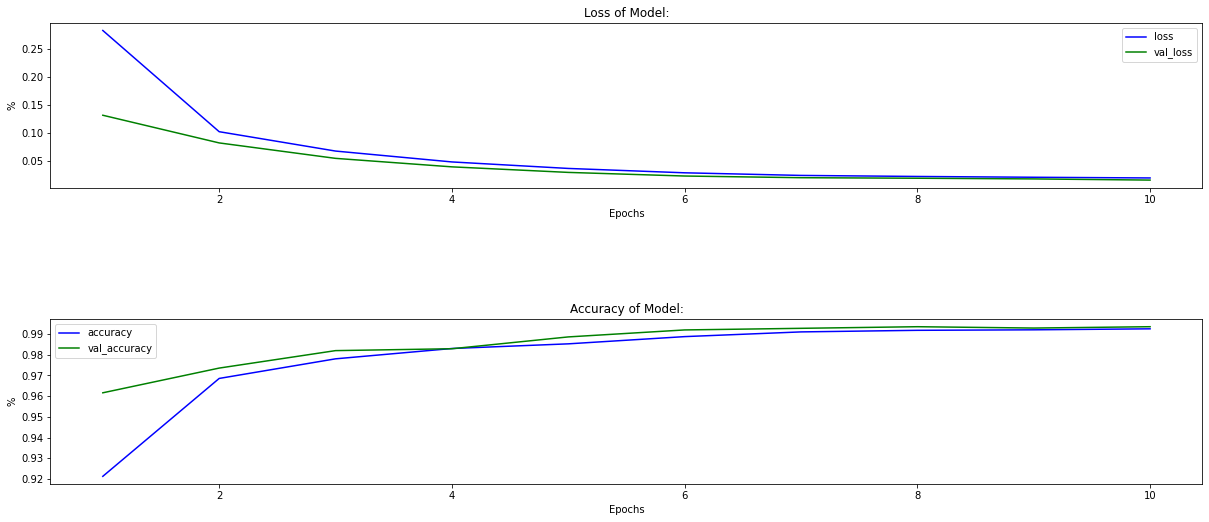

Baseline test accuracy: 0.9947068095207214
Clustered test accuracy: 0.992786705493927
Saving clustered model to:  Clustering\clustered_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpfjsjkbnl\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpfjsjkbnl\assets


Saved clustered TFLite model to: Clustering\clustered_tflite_model.tflite
Size of gzipped baseline Keras model: 289662.00 bytes
Size of gzipped clustered Keras model: 53979.00 bytes
Size of gzipped clustered TFlite model: 52990.00 bytes


In [20]:
keras_model, final_model = weight_clustering("fnn_model.h5", train_data, train_labels, test_data, test_labels, 128, 10, "Clustering")

# Clustering & Post-training Quantization

In [23]:

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

quantized_and_clustered_tflite_file = os.path.join("Clustering", "quantized_clustered_tflite_model.tflite")

with open(quantized_and_clustered_tflite_file, 'wb') as f:
  f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
# print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_model)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_clustered_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpzc4sy5is\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpzc4sy5is\assets


Saved quantized and clustered TFLite model to: Clustering\quantized_clustered_tflite_model.tflite
Size of gzipped clustered and quantized TFlite model: 40828.00 bytes


In [24]:
import numpy as np

def evaluate_model(interpreter, test_data, test_labels):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # test_labels = np.argmax(test_labels, axis=1)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_sample in enumerate(test_data):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_sample)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [25]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_data, test_labels)

print('Clustered and quantized TFLite test_accuracy:', test_accuracy)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.
Evaluated on 11000 results so far.
Evaluated on 12000 results so far.
Evaluated on 13000 results so far.
Evaluated on 14000 results so far.
Evaluated on 15000 results so far.
Evaluated on 16000 results so far.
Evaluated on 17000 results so far.
Evaluated on 18000 results so far.
Evaluated on 19000 results so far.


Clustered and quantized TFLite test_accuracy: 0.9921120913336793
